In [1]:
import numpy as np
# import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
# from torch.nn.functional import /relu
import torch.nn as nn
# import torch.nn.functional as Func
# import torch.optim as optim
import utils
from utils import *
from loupe_env.loupe_wrap import LOUPE
from MoDL.MoDL import MoDL
from matplotlib import pyplot as plt
import random
import copy
# from sklearn.model_selection import train_test_split

# import skimage
from mnet.mnet_v2 import MNet
from unet.unet_model import UNet
from unet.unet_model_fbr import Unet
from unet.unet_model_banding_removal_fbr import UnetModel
# from mask_backward_v4 import *
# from sigpy.mri.app import TotalVariationRecon

# torch.manual_seed(0)
# np.random.seed(0)
# random.seed(0)

In [2]:
testdata = torch.tensor(np.load('/mnt/shared_a/fastMRI/knee_singlecoil_test.npz')['data'])
print('test data shape:',testdata.shape)

for ind in range(testdata.shape[0]):
    testdata[ind,:,:] = testdata[ind,:,:]/torch.max(torch.abs(testdata[ind,:,:]))
print('test data size:', testdata.shape)

device = torch.device('cuda:0')
# device = torch.device('cpu')

test data shape: torch.Size([1300, 320, 320])
test data size: torch.Size([1300, 320, 320])


In [3]:
# specify sampling parameters
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)

print(f'base corefreq is {preselect_num}, sampling budget is {budget}')

base corefreq is 8, sampling budget is 32


# Evaluation

## evaluate MNet - UNet

In [ ]:
# specify sampling parameters
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)

print(f'base corefreq is {preselect_num}, sampling budget is {budget}')

# load mnet
mnet = MNet(beta=1,in_chans=2,out_size=320-preselect_num, imgsize=(heg,wid),poolk=3)
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

In [ ]:
# load unet-SEP
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_epoch_39.pt'

checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = mnet_eval(testdata,mnet,unet_recon,\
                                          base=preselect_num,budget=budget,batchsize=10,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetunet.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

In [ ]:
# specify sampling parameters
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)

print(f'base corefreq is {preselect_num}, sampling budget is {budget}')

# load mnet
mnet = MNet(beta=1,in_chans=2,out_size=320-preselect_num, imgsize=(heg,wid),poolk=3)
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

# load unet-CO
unet_recon = unet = UNet(in_chans=1,n_classes=1,bilinear=False,skip=True)
unetpath = '/mnt/shared_a/checkpoints/leo/mri/unet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = mnet_eval(testdata,mnet,unet_recon,\
                                          base=preselect_num,budget=budget,batchsize=10,device='cuda:0')

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetunet_direct.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate fix_loupe - Unet (Mar, for review response)

In [4]:
# load unet
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64).to(device)
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_aug_False_fix_base8_budget32_epoch_37.pt'

checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

Unet loaded successfully from: /mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_aug_False_fix_base8_budget32_epoch_37.pt
nn's are ready


In [5]:
maskfile = '/mnt/shared_a/checkpoints/leo/mri/loupe_mask_8fold.pt'
fix_mask = torch.load(maskfile)['mask']

In [ ]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,model=unet_recon,mode='fix',\
                                          base=preselect_num,budget=budget,batchsize=10,device=device,\
                                          fix_mask=fix_mask)

<Figure size 432x288 with 0 Axes>

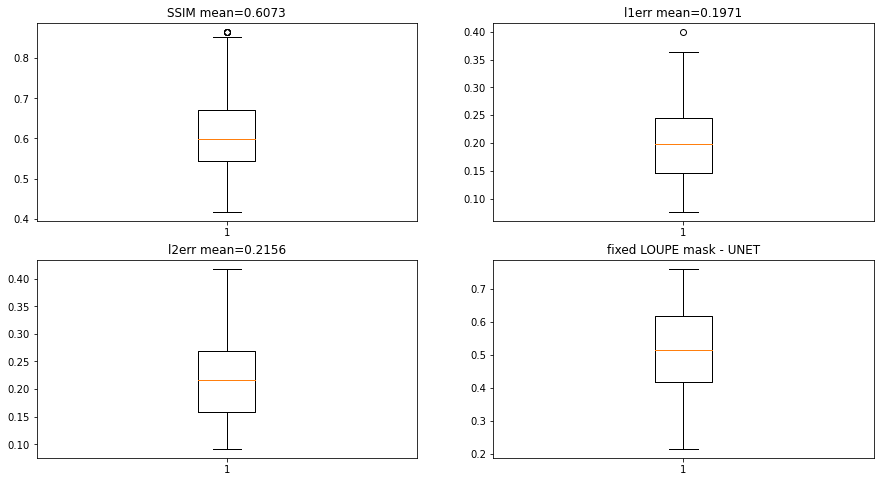

In [13]:
plt.clf()

figsize = (15,8)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=figsize)

axs[0,0].boxplot(ssims.numpy())
axs[0,0].set_title(f'SSIM mean={ssims.numpy().mean():.4f}')

# plt.boxplot(psnrs.numpy())
# plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
# plt.show()

axs[0,1].boxplot(l1err.numpy())
axs[0,1].set_title(f'l1err mean={l1err.numpy().mean():.4f}')

axs[1,0].boxplot(l2err.numpy())
axs[1,0].set_title(f'l2err mean={l2err.numpy().mean():.4f}')

axs[1,1].boxplot(hfens.numpy())
axs[1,1].set_title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.title('fixed LOUPE mask - UNET - SET')
plt.show()

test data size: torch.Size([1300, 320, 320])


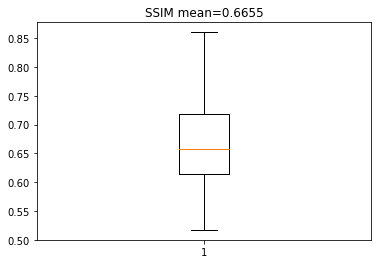

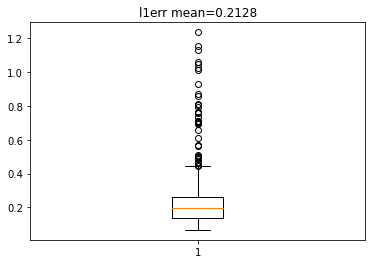

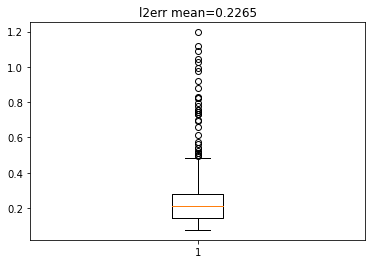

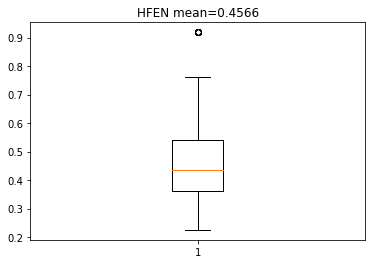

In [6]:
filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_loupe_fix.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate Rand - MoDL (Feb, for review response)

In [7]:
modl = MoDL(in_chans=2,out_chans=2,chans=64,num_pool_layers=4,drop_prob=0,CG_steps=6) # CG_steps=6 not 4
modlpath = '/mnt/shared_a/checkpoints/leo/recon/MoDL_2_chans_64_epoch_39.pt' # for rand, previous ones were overwritten
checkpoint = torch.load(modlpath)
modl.load_state_dict(checkpoint['model_state_dict'])
print(f'MoDL model loaded successfully from {modlpath}')

MoDL model loaded successfully from /mnt/shared_a/checkpoints/leo/recon/MoDL_2_chans_64_epoch_39.pt


In [8]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,modl,\
                                          base=preselect_num,budget=budget,batchsize=5,mode='rand',device=device)

test data size: torch.Size([1300, 320, 320])


<Figure size 432x288 with 0 Axes>

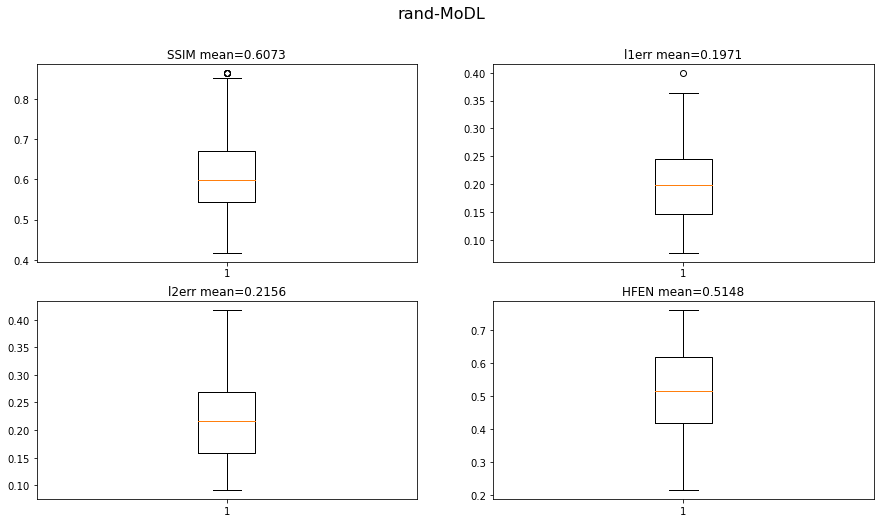

In [10]:
plt.clf()
figsize = (15,8)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=figsize)

axs[0,0].boxplot(ssims.numpy())
axs[0,0].set_title(f'SSIM mean={ssims.numpy().mean():.4f}')

# axs[0,1].boxplot(psnrs.numpy())
# axs[0,1].set_title(f'PSNR mean={psnrs.numpy().mean():.4f}')

axs[0,1].boxplot(l1err.numpy())
axs[0,1].set_title(f'l1err mean={l1err.numpy().mean():.4f}')

axs[1,0].boxplot(l2err.numpy())
axs[1,0].set_title(f'l2err mean={l2err.numpy().mean():.4f}')

axs[1,1].boxplot(hfens.numpy())
axs[1,1].set_title(f'HFEN mean={hfens.numpy().mean():.4f}')

# axs[1,2].axis('off')

fig.suptitle('rand-MoDL', fontsize=16)
plt.show()

<Figure size 432x288 with 0 Axes>

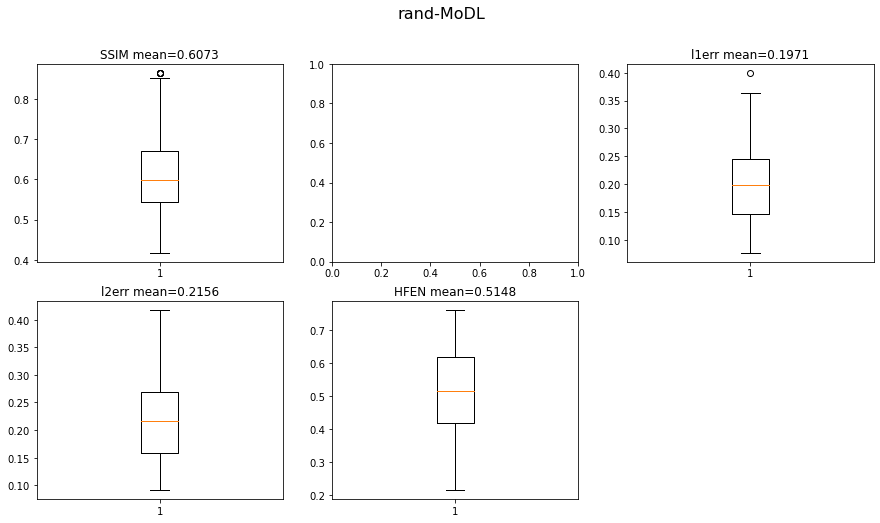

In [9]:
filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_rand__modl_chans64.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate MNet - MoDL

In [ ]:
modl = MoDL(in_chans=2,out_chans=2,chans=64,num_pool_layers=4,drop_prob=0,CG_steps=4)
modlpath = '/mnt/shared_a/checkpoints/leo/recon/MoDL_2_chans_64_epoch_39.pt'
checkpoint = torch.load(modlpath)
modl.load_state_dict(checkpoint['model_state_dict'])
print(f'MoDL model loaded successfully from {modlpath}')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = mnet_eval(testdata,mnet,modl,\
                                          base=preselect_num,budget=budget,batchsize=5,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

# filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetmodl_chans64.npz'
# np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate baseline --- prob

In [ ]:
# load unet
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64).to(device)
# unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_prob_epoch_39.pt'
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_prob_epoch_39.pt'

checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
# compute energy distribution from train data
traindata = torch.tensor(np.load('/mnt/shared_a/fastMRI/knee_singlecoil_train.npz')['data'])
for ind in range(traindata.shape[0]):
    traindata[ind,:,:] = traindata[ind,:,:]/torch.max(torch.abs(traindata[ind,:,:]))
print('train data shape:',traindata.shape)

num_pts = traindata.shape[0]
imgHeg  = traindata.shape[1]

y_full  = F.fftn(traindata,dim=(1,2),norm='ortho')
del traindata
y_full  = F.fftshift(y_full,dim=(1,2))

energy_vec = torch.zeros(imgHeg)
for img_fft in y_full:
    energy_vec += torch.sum(torch.square(torch.abs(img_fft)).to(torch.float),dim=1)
energy_vec /= num_pts       # average by total amount of samples
energy_vec /= torch.sum(energy_vec) # normalized by total energy
del y_full

plt.figure()
plt.scatter(range(len(energy_vec)),energy_vec)
plt.yscale('log')
plt.show()
energy_vec.sum()
filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_prob_energy_vec.npz'
np.savez(filename,energy_vec=energy_vec)

In [ ]:
filename = '/home/huangz78/mri/energy_vec_base16_budget64_.pt' # this file is wrong, Feb 26, 13:43
energy_vec = torch.load(filename)['energy_vec']

In [2]:
filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_prob_energy_vec.npz'
energy_vec = np.load(filename)['energy_vec']

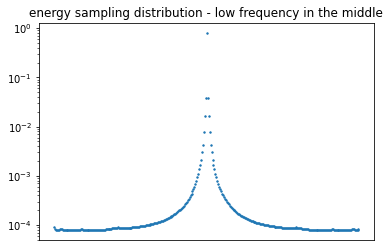

In [11]:
plt.figure()
plt.scatter(range(len(energy_vec)),energy_vec,s=2)
plt.xticks([])
plt.yscale('log')
plt.title('energy sampling distribution - low frequency in the middle')
plt.show()

In [ ]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,model=unet_recon,mode='prob',energy_vec=energy_vec,\
                                          base=preselect_num,budget=budget,batchsize=10,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_prob.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate baseline --- rand and equidist

In [ ]:
# load unet
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_rand_epoch_38.pt'

checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,model=unet_recon,mode='rand',\
                                          base=preselect_num,budget=budget,batchsize=10,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_rand.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

In [ ]:
# load unet
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_aug_True_equidist_epoch_38.pt'
# unet_fbr_2_chans_64_equidist_epoch_39.pt
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,model=unet_recon,mode='equidist',\
                                          base=preselect_num,budget=budget,batchsize=10,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_equidist.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

In [ ]:
# load unet
unet_inchannels = 2
unet_recon = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unetpath = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_equidist_epoch_39.pt'
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

In [ ]:
l1err,l2err,hfens,ssims,psnrs = baseline_eval(testdata,model=unet_recon,mode='equidist',\
                                          base=preselect_num,budget=budget,batchsize=10,device=device)

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_equidist.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

## evaluate LOUPE

In [ ]:
# load loupe model
loupepath = '/mnt/shared_a/checkpoints/leo/mri/loupe_8fold_base_8_epoch_39.pt'
loupe = LOUPE(in_chans=1,unet_skip=False,shape=[heg,wid],sparsity=sparsity,\
                  preselect=True,preselect_num=preselect_num)

checkpoint = torch.load(loupepath)
loupe.load_state_dict(checkpoint['model_state_dict'])
loupe.eval()
print(f'loupe model is successfully imported from : {loupepath}')

In [ ]:
loupe_mask_highfreq = torch.sigmoid(loupe.samplers[0].gen_mask.slope * loupe.samplers[0].gen_mask.mask)

help(mask_complete)

if len(loupe_mask_highfreq.shape) == 1:
    loupe_mask_highfreq = loupe_mask_highfreq.view(1,-1)
loupe_mask_full = mask_complete(loupe_mask_highfreq,320,rolled=False)

_,indices = torch.sort(loupe_mask_full[0],descending=True)

loupe_mask_fixed = torch.zeros_like(loupe_mask_full)
loupe_mask_fixed[0,indices[0:preselect_num+budget]] = 1

kplot(loupe_mask_fixed[0,:].detach().numpy(),roll=True)

filename = '/mnt/shared_a/checkpoints/leo/mri/loupe_mask_8fold.pt'
torch.save({'mask':loupe_mask_fixed},filename)

In [ ]:
l1err,l2err,hfens,ssims,psnrs = loupe_eval(loupe,testdata,\
                                           preselect_num=preselect_num,sparsity=sparsity,\
                                           batchsize=10,device=torch.device('cuda:0'))

plt.boxplot(ssims.numpy())
plt.title(f'SSIM mean={ssims.numpy().mean():.4f}')
plt.show()

plt.boxplot(psnrs.numpy())
plt.title(f'PSNR mean={psnrs.numpy().mean():.4f}')
plt.show()

plt.boxplot(l1err.numpy())
plt.title(f'l1err mean={l1err.numpy().mean():.4f}')
plt.show()

plt.boxplot(l2err.numpy())
plt.title(f'l2err mean={l2err.numpy().mean():.4f}')
plt.show()

plt.boxplot(hfens.numpy())
plt.title(f'HFEN mean={hfens.numpy().mean():.4f}')
plt.show()

filename = '/mnt/shared_a/checkpoints/leo/mri/8fold_loupe.npz'
np.savez(filename,l1err=l1err,l2err=l2err,hfens=hfens,ssims=ssims,psnrs=psnrs)

# Make figures

## Accuracy plots

In [ ]:
dir_rec1 = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetunet_direct.npz'
dir_rec2 = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetunet.npz'
dir_rec3 = '/mnt/shared_a/checkpoints/leo/mri/8fold_mnetmodl_chans64.npz'
dir_rec4 = '/mnt/shared_a/checkpoints/leo/mri/8fold_loupe.npz'
dir_rec5 = '/mnt/shared_a/checkpoints/leo/mri/8fold_rand.npz'
dir_rec6 = '/mnt/shared_a/checkpoints/leo/mri/8fold_equidist.npz'
dir_rec7 = '/mnt/shared_a/checkpoints/leo/mri/8fold_prob.npz'

In [ ]:
rec1 = np.load(dir_rec1)
l1err_mnetunet_dir,l2err_mnetunet_dir,hfens_mnetunet_dir,ssims_mnetunet_dir,psnrs_mnetunet_dir = \
rec1['l1err'], rec1['l2err'], rec1['hfens'], rec1['ssims'], rec1['psnrs']

rec2 = np.load(dir_rec2)
l1err_mnetunet,l2err_mnetunet,hfens_mnetunet,ssims_mnetunet,psnrs_mnetunet = \
rec2['l1err'], rec2['l2err'], rec2['hfens'], rec2['ssims'], rec2['psnrs']

rec3 = np.load(dir_rec3)
l1err_mnetmodl,l2err_mnetmodl,hfens_mnetmodl,ssims_mnetmodl,psnrs_mnetmodl = \
rec3['l1err'], rec3['l2err'], rec3['hfens'], rec3['ssims'], rec3['psnrs']

rec4 = np.load(dir_rec4)
l1err_loupe,l2err_loupe,hfens_loupe,ssims_loupe,psnrs_loupe = \
rec4['l1err'], rec4['l2err'], rec4['hfens'], rec4['ssims'], rec4['psnrs']

rec5 = np.load(dir_rec5)
l1err_rand,l2err_rand,hfens_rand,ssims_rand,psnrs_rand = \
rec5['l1err'], rec5['l2err'], rec5['hfens'], rec5['ssims'], rec5['psnrs']

rec6 = np.load(dir_rec6)
l1err_equidist,l2err_equidist,hfens_equidist,ssims_equidist,psnrs_equidist = \
rec6['l1err'], rec6['l2err'], rec6['hfens'], rec6['ssims'], rec6['psnrs']

rec7 = np.load(dir_rec7)
l1err_prob,l2err_prob,hfens_prob,ssims_prob,psnrs_prob = \
rec7['l1err'], rec7['l2err'], rec7['hfens'], rec7['ssims'], rec7['psnrs']

In [ ]:
file = rec6
for key in file.files:
    print(f'{key}: {np.mean(file[key])}')

In [ ]:
file = rec6
key = 'l2err'
print(f'NMSE: { np.mean(file[key]**2) }')

In [ ]:
# Figure: Accuracy comparison

figsize=(29,17)
label_fontsize = 26
xtick_fontsize  = 19
ytick_fontsize  = 26
rotation_angle = 19
nrows=2
ncols=2

plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
labels = ['MNet-Unet-co', 'MNet-Unet-sep','MNet-MoDL','LOUPE','Energy-Unet','Rand.-Unet', 'Equidist.-Unet']

data = [l1err_mnetunet_dir,l1err_mnetunet,l1err_mnetmodl,l1err_loupe,l1err_prob,l1err_rand,l1err_equidist]
axs[0,0].boxplot(data,notch=True,showmeans=True)
axs[0,0].set_xticklabels(labels,fontsize=label_fontsize)
axs[0,0].set_ylabel(r"Rel. $\ell_1$ error",fontsize=label_fontsize)
axs[0,0].set_ylim([0, 0.5])
axs[0,0].tick_params(axis='x', which='major', labelsize=xtick_fontsize,rotation=rotation_angle)
axs[0,0].tick_params(axis='y', which='major', labelsize=ytick_fontsize,rotation=0)

data = [l2err_mnetunet_dir**2,l2err_mnetunet**2,l2err_mnetmodl**2,l2err_loupe**2,l2err_prob**2,l2err_rand**2,l2err_equidist**2]
axs[0,1].boxplot(data,notch=True,showmeans=True)
axs[0,1].set_xticklabels(labels,fontsize=label_fontsize)
axs[0,1].set_ylabel(r"NMSE",fontsize=label_fontsize)
# axs[0,1].set_ylabel(r"Rel. $\ell_2$ error",fontsize=label_fontsize)
axs[0,1].set_ylim([0, 0.1])
axs[0,1].tick_params(axis='x', which='major', labelsize=xtick_fontsize,rotation=rotation_angle)
axs[0,1].tick_params(axis='y', which='major', labelsize=ytick_fontsize,rotation=0)

data = [hfens_mnetunet_dir,hfens_mnetunet,hfens_mnetmodl,hfens_loupe,hfens_prob,hfens_rand,hfens_equidist]
axs[1,0].boxplot(data,notch=True,showmeans=True)
axs[1,0].set_xticklabels(labels,fontsize=label_fontsize)
axs[1,0].set_ylabel(r"HFEN",fontsize=label_fontsize)
axs[1,0].set_ylim([0, 1])
axs[1,0].tick_params(axis='x', which='major', labelsize=xtick_fontsize,rotation=rotation_angle)
axs[1,0].tick_params(axis='y', which='major', labelsize=ytick_fontsize,rotation=0)

data = [ssims_mnetunet_dir,ssims_mnetunet,ssims_mnetmodl,ssims_loupe,ssims_prob,ssims_rand,ssims_equidist]
axs[1,1].boxplot(data,notch=True,showmeans=True)
axs[1,1].set_xticklabels(labels,fontsize=label_fontsize)
axs[1,1].set_ylabel(r"SSIM",fontsize=label_fontsize)
axs[1,1].tick_params(axis='x', which='major', labelsize=xtick_fontsize,rotation=rotation_angle)
axs[1,1].tick_params(axis='y', which='major', labelsize=ytick_fontsize,rotation=0)

# data = [psnrs_mnetunet_dir/2,psnrs_mnetunet/2,psnrs_mnetmodl,psnrs_loupe/2,psnrs_rand/2,psnrs_equidist/2]
# axs[1,1].boxplot(data,notch=True,showmeans=True)
# axs[1,1].set_xticklabels(labels,fontsize=label_fontsize)
# axs[1,1].set_ylabel(r"PSNR",fontsize=label_fontsize)
# axs[1,1].tick_params(axis='x', which='major', labelsize=xtick_fontsize,rotation=rotation_angle)
# axs[1,1].tick_params(axis='y', which='major', labelsize=ytick_fontsize,rotation=0)

# axs[-1, -1].axis('off')
fig_curr = plt.gcf()
plt.show()
plt.draw()
dir_fig = '/home/huangz78/mri/figures/accuracy_8fold.eps'
fig_curr.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

## Recon example plots

In [ ]:
# specify sampling parameters
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)

print(f'base corefreq is {preselect_num}, sampling budget is {budget}')

# load mnet
mnet = MNet(beta=1,in_chans=2,out_size=320-preselect_num, imgsize=(heg,wid),poolk=3)
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

## load Unet-CO
unet_co = UNet(in_chans=1,n_classes=1,bilinear=False,skip=True)
unet_co_path = '/mnt/shared_a/checkpoints/leo/mri/unet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(unet_co_path)
unet_co.load_state_dict(checkpoint['model_state_dict'])
unet_co.eval()
print('Unet_co loaded successfully from: ' + unet_co_path )

# load unet-SEP
unet_inchannels = 2
unet_sep = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unet_sep_path = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_epoch_39.pt'

checkpoint = torch.load(unet_sep_path)
unet_sep.load_state_dict(checkpoint['model_state_dict'])
unet_sep.eval()
print('Unet_sep loaded successfully from: ' + unet_sep_path )

# load MoDL
modl = MoDL(in_chans=2,out_chans=2,chans=64,num_pool_layers=4,drop_prob=0,CG_steps=4)
modlpath = '/mnt/shared_a/checkpoints/leo/recon/MoDL_mnet_2_chans_64_base8_budget32_epoch_39.pt'
checkpoint = torch.load(modlpath)
modl.load_state_dict(checkpoint['model_state_dict'])
modl.eval()
print(f'MoDL model loaded successfully from {modlpath}')

# load loupe model
loupepath = '/mnt/shared_a/checkpoints/leo/mri/loupe_8fold_base_8_epoch_39.pt'
loupe = LOUPE(in_chans=1,unet_skip=False,shape=[heg,wid],sparsity=sparsity,\
                  preselect=True,preselect_num=preselect_num)

checkpoint = torch.load(loupepath)
loupe.load_state_dict(checkpoint['model_state_dict'])
loupe.eval()
print(f'loupe model is successfully imported from : {loupepath}')

# load baseline - Unet_Rand
unet_inchannels = 2
unet_rand = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unet_rand_path = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_rand_epoch_38.pt'

checkpoint = torch.load(unet_rand_path)
unet_rand.load_state_dict(checkpoint['model_state_dict'])
unet_rand.eval()
print('Unet_rand loaded successfully from: ' + unet_rand_path )

# load baseline - Unet-Equidist
unet_inchannels = 2
unet_equidist = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unet_equidist_path = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_equidist_epoch_39.pt'

checkpoint = torch.load(unet_equidist_path)
unet_equidist.load_state_dict(checkpoint['model_state_dict'])
unet_equidist.eval()
print('Unet loaded successfully from: ' + unet_equidist_path )

# load baseline - Unet-Energy
# load unet
unet_inchannels = 2
unet_prob = Unet(in_chans=unet_inchannels,out_chans=1,chans=64)
unet_prob_path = '/mnt/shared_a/checkpoints/leo/recon/unet_fbr_2_chans_64_prob_epoch_39.pt'

checkpoint = torch.load(unet_prob_path)
unet_prob.load_state_dict(checkpoint['model_state_dict'])
unet_prob.eval()
energy_filepath = '/mnt/shared_a/checkpoints/leo/mri/8fold_prob_energy_vec.npz'
energy_vec = np.load(energy_filepath)['energy_vec']
print('Unet loaded successfully from: ' + unet_prob_path )

In [ ]:
imgind = 648 # np.random.randint(testdata.shape[0]) # val 684, 1153, 648, test 648
print(f'current image index: {imgind}')
img    = testdata[imgind,:,:].unsqueeze(0).to(torch.float)
batchsize = 1
print(f'shape of img: {img.shape}')

plt.figure()
plt.imshow(img[0,:,:],origin='lower')
plt.title('ground truth')
plt.colorbar()
plt.show()

model_in_chans = 1
with torch.no_grad():
    test_1ch, mask_1ch = mnet_getinput(mnet,img,base=preselect_num,budget=budget,batchsize=batchsize,\
                                  unet_channels=model_in_chans,return_mask=True,device=device)
print(f'shape of test_1ch: {test_1ch.shape}')
print(f'shape of mask_1ch: {mask_1ch.shape}')

model_in_chans = 2
with torch.no_grad():
    test_2ch, mask_2ch = mnet_getinput(mnet,img,base=preselect_num,budget=budget,batchsize=batchsize,\
                                  unet_channels=model_in_chans,return_mask=True,device=device)
print(f'shape of test_2ch: {test_2ch.shape}')
print(f'shape of mask_2ch: {mask_2ch.shape}')

model_in_chans = 2
with torch.no_grad():
    test_rand, mask_rand = base_getinput(img,base=preselect_num,budget=budget,batchsize=batchsize,\
                                  unet_channels=model_in_chans,mode='rand',return_mask=True)
print(f'shape of test_rand: {test_rand.shape}')
print(f'shape of mask_rand: {mask_rand.shape}')

model_in_chans = 2
with torch.no_grad():
    test_equidist, mask_equidist = base_getinput(img,base=preselect_num,budget=budget,batchsize=batchsize,\
                            unet_channels=model_in_chans,mode='equidist',return_mask=True)
print(f'shape of test_equidist: {test_equidist.shape}')
print(f'shape of mask_equidist: {mask_equidist.shape}')

model_in_chans = 2
with torch.no_grad():
    test_prob, mask_prob = energydist_getinput(img,base=preselect_num,budget=budget,\
                                               unet_channels=model_in_chans,energy_vec=energy_vec,return_dist=True)
print(f'shape of test_prob: {test_prob.shape}')
print(f'shape of mask_prob: {mask_prob.shape}')

In [ ]:
kplot(mask_prob[0,:],roll=False)

 - Mnet-Unet-Co

In [ ]:
with torch.no_grad():
    recon_co = unet_co(test_1ch).detach()
    nmse_co  = lpnorm(recon_co,img.unsqueeze(1))**2
    ssim_co  = ssim_uniform(recon_co,img.unsqueeze(1))
    psnr_co  = compute_psnr(recon_co,img.unsqueeze(1))
    recon_co = recon_co[0,0,:,:] # 2D image
    print(f'nmse_co = {nmse_co}')
    print(f'ssim_co = {ssim_co}')
    print(f'psnr_co = {psnr_co.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_co,origin='lower')
plt.colorbar()
plt.show()

 - Mnet-Unet-Sep

In [ ]:
with torch.no_grad():
    recon_sep = unet_sep(test_2ch).detach()
    nmse_sep  = lpnorm(recon_sep,img.unsqueeze(1))**2
    ssim_sep  = ssim_uniform(recon_sep,img.unsqueeze(1))
    psnr_sep  = compute_psnr(recon_sep,img.unsqueeze(1))
    recon_sep = recon_sep[0,0,:,:] # 2D image
    print(f'nmse_sep = {nmse_sep}')
    print(f'ssim_sep = {ssim_sep}')
    print(f'psnr_sep = {psnr_sep.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_sep,origin='lower')
plt.colorbar()
plt.show()

 - Mnet-MoDL

In [ ]:
mask = torch.zeros_like(img,dtype=torch.float)
mask[0] = mask_2ch[0].unsqueeze(1).repeat(1,img.shape[2])
mask = mask.unsqueeze(1).repeat(1,2,1,1)

smap = torch.ones(test_2ch.shape).unsqueeze(1)
with torch.no_grad():
    recon_modl = modl(test_2ch,smap,mask).detach()
    nmse_modl  = lpnorm(recon_modl[0:1,0:1,:,:],img.unsqueeze(1))**2
    ssim_modl  = ssim_uniform(recon_modl[0:1,0:1,:,:],img.unsqueeze(1))
    psnr_modl  = compute_psnr(recon_modl[0:1,0:1,:,:],img.unsqueeze(1))
    recon_modl = recon_modl[0,0,:,:] # 2D image
    print(f'nmse_modl = {nmse_modl}')
    print(f'ssim_modl = {ssim_modl}')
    print(f'psnr_modl = {psnr_modl.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_modl,origin='lower')
plt.colorbar()
plt.show()

 - LOUPE

In [ ]:
xstar = img.unsqueeze(1).to(torch.float)
ystar = F.fftn(xstar,dim=(2,3),norm='ortho')

with torch.no_grad():
    recon_loupe,mask_loupe = loupe(ystar)
    nmse_loupe  = lpnorm(recon_loupe,img.unsqueeze(1))**2
    ssim_loupe  = ssim_uniform(recon_loupe,img.unsqueeze(1))
    psnr_loupe  = compute_psnr(recon_loupe,img.unsqueeze(1))
    recon_loupe = recon_loupe.detach()[0,0,:,:]

    mask_loupe = torch.squeeze(mask_loupe.detach())

    print(f'shape of mask_loupe: {mask_loupe.shape}')
    print(f'nmse_modl = {nmse_loupe}')
    print(f'ssim_loupe = {ssim_loupe}')
    print(f'psnr_loupe = {psnr_loupe.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_loupe,origin='lower')
plt.colorbar()
plt.show()

 - rand, baseline

In [ ]:
with torch.no_grad():
    recon_rand = unet_rand(test_rand).detach()
    nmse_rand  = lpnorm(recon_rand,img.unsqueeze(1))**2
    ssim_rand  = ssim_uniform(recon_rand,img.unsqueeze(1))
    psnr_rand  = compute_psnr(recon_rand,img.unsqueeze(1))
    recon_rand = recon_rand[0,0,:,:] # 2D image
    print(f'nmse_rand = {nmse_rand}')
    print(f'ssim_rand = {ssim_rand}')
    print(f'psnr_rand = {psnr_rand.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_rand,origin='lower')
plt.colorbar()
plt.show()

 - equidist., baseline

In [ ]:
with torch.no_grad():
    recon_equidist = unet_equidist(test_equidist).detach()
    nmse_equidist  = lpnorm(recon_equidist,img.unsqueeze(1))**2
    ssim_equidist  = ssim_uniform(recon_equidist,img.unsqueeze(1))
    psnr_equidist  = compute_psnr(recon_equidist,img.unsqueeze(1))
    recon_equidist = recon_equidist[0,0,:,:] # 2D image
    print(f'nmse_equidist = {nmse_equidist}')
    print(f'ssim_equidist = {ssim_equidist}')
    print(f'psnr_equidist = {psnr_equidist.item()}')

In [ ]:
plt.figure()
plt.imshow(recon_equidist,origin='lower')
plt.colorbar()
plt.show()

- prob., baseline

In [ ]:
model_in_chans = 2
with torch.no_grad():
    test_prob, mask_prob = energydist_getinput(img,base=preselect_num,budget=budget,\
                                               unet_channels=model_in_chans,energy_vec=energy_vec,return_dist=True)

with torch.no_grad():
    recon_prob = unet_prob(test_prob).detach()
    nmse_prob  = lpnorm(recon_prob,img.unsqueeze(1))**2
    ssim_prob  = ssim_uniform(recon_prob,img.unsqueeze(1))
    psnr_prob  = compute_psnr(recon_prob,img.unsqueeze(1))
    recon_prob = recon_prob[0,0,:,:] # 2D image
    print(f'nmse_prob = {nmse_prob}')
    print(f'ssim_prob = {ssim_prob}')
    print(f'psnr_prob = {psnr_prob.item()}')

In [ ]:
imgFile = '/mnt/shared_a/checkpoints/leo/recon/recon_imgs.pt'
torch.save({'recon_co':recon_co,'recon_sep':recon_sep,'recon_modl':recon_modl,'recon_loupe':recon_loupe,\
            'recon_rand':recon_rand,'recon_equidist':recon_equidist,'prob':recon_prob},imgFile)

- make plots

In [ ]:
figsize=(21,15)
label_fontsize  = 15

nrows=2; 
ncols=4

plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
labels = ['MNet-Unet-co', 'MNet-Unet-sep','MNet-MoDL','LOUPE','Prob.-Unet','Rand.-Unet', 'Equidist.-Unet']

axs[0,0].imshow(img[0,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title('Ground truth,  SSIM,  NMSE',fontsize=label_fontsize) #, PSNR

# axs[0,0].axis('off')
# axs[1,0].axis('off')

axs[0,1].imshow(recon_co,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title(f'MNet-Unet-CO,  {ssim_co:.4f},  {nmse_co.item():.5f}',fontsize=label_fontsize) #, {psnr_co.item():.4f}

axs[0,2].imshow(recon_sep,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title(f'MNet-Unet-SEP,  {ssim_sep:.4f},  {nmse_sep.item():.5f}',fontsize=label_fontsize) #, {psnr_sep.item():.4f}

axs[0,3].imshow(recon_modl,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,3].set_xticks([])
axs[0,3].set_yticks([])
# axs[0,3].set_title(f'MNet-MoDL,  {ssim_modl:.4f},  {nmse_modl.item():.5f}',fontsize=label_fontsize) #, {psnr_modl.item():.4f}
axs[0,3].set_title(f'MNet-MoDL,  {0.8319:.4f},  {0.01013:.5f}',fontsize=label_fontsize) #, {psnr_modl.item():.4f}


axs[1,0].imshow(recon_loupe,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,0].set_title(f'LOUPE, {ssim_loupe:.4f}, {nmse_loupe.item():.5f}',fontsize=label_fontsize) #, {psnr_loupe.item():.4f}

axs[1,1].imshow(recon_prob,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].set_title(f'prob.-Unet, {ssim_prob:.4f}, {nmse_prob.item():.5f}',fontsize=label_fontsize) #, {psnr_loupe.item():.4f}

axs[1,2].imshow(recon_rand,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])
axs[1,2].set_title(f'rand.-Unet,  {ssim_rand:.4f},  {nmse_rand.item():.5f}',fontsize=label_fontsize) #, {psnr_rand.item():.4f}

axs[1,3].imshow(recon_equidist,cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,3].set_xticks([])
axs[1,3].set_yticks([])
axs[1,3].set_title(f'equidist.-Unet,  {ssim_equidist:.4f},  {nmse_equidist.item():.5f}',fontsize=label_fontsize) #, {psnr_rand.item():.4f}

plt.subplots_adjust(wspace=.02, hspace=-.35)
fig_curr = plt.gcf()
plt.show()
plt.draw()
dir_fig = '/home/huangz78/mri/figures/8fold_recon_examples_new.eps'
fig_curr.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

## Mask example plots

- masks for this image: MNet, LOUPE, rand, equidist

In [ ]:
def mask_1dTo2d(masks,heg=320,wid=320):
    '''
    the input masks have the shape NH
    '''
    masks2d = torch.zeros(len(masks),heg,wid,dtype=torch.float)
    for ind in range(len(masks)):
        mask1d = masks[ind]
        masks2d[ind] = mask1d.unsqueeze(1).repeat(1,wid)
    return masks2d

In [ ]:
mask_mnet     = mask_1dTo2d(mask_1ch)
mask_loupe    = mask_1dTo2d(mask_loupe.unsqueeze(0))
mask_rand     = mask_1dTo2d(mask_rand)
mask_equidist = mask_1dTo2d(mask_equidist)
mask_prob     = mask_1dTo2d(mask_prob)
# mask_rand     = mask_1dTo2d(mask_rand.unsqueeze(0))
# mask_equidist = mask_1dTo2d(mask_equidist.unsqueeze(0))
# mask_prob     = mask_1dTo2d(mask_prob.unsqueeze(0))

In [ ]:
figsize=(18,18)
label_fontsize  = 15

nrows=1; 
ncols=5

plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)

axs[0].imshow(F.fftshift(mask_mnet[0,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('MNet',fontsize=label_fontsize)

axs[1].imshow(F.fftshift(mask_loupe[0,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('LOUPE',fontsize=label_fontsize)

axs[2].imshow(F.fftshift(mask_rand[0,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Random',fontsize=label_fontsize)

axs[3].imshow(F.fftshift(mask_equidist[0,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title('Equi-distance',fontsize=label_fontsize)

axs[4].imshow(mask_prob[0,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
axs[4].set_xticks([])
axs[4].set_yticks([])
axs[4].set_title('Energy-samp',fontsize=label_fontsize)


plt.subplots_adjust(wspace=.015, hspace=0)
fig_curr = plt.gcf()
plt.show()
plt.draw()
dir_fig = '/home/huangz78/mri/figures/8fold_masks_new.eps'
fig_curr.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

- Examples of multiple MNet masks 

In [ ]:
batchsize = 3
imginds = np.random.randint(testdata.shape[0],size=batchsize)
imginds = [1246 , 219 , 167]
print(f'current image index: {imginds}')
imgs   = testdata[imginds,:,:]
print(f'shape of img: {imgs.shape}')

_, masks = mnet_getinput(mnet,imgs,base=preselect_num,budget=budget,batchsize=batchsize,\
                                  unet_channels=1,return_mask=True,device=device)
print(f'shape of masks: {masks.shape}')
masks = mask_1dTo2d(masks)

In [ ]:
figsize=(12,7)
label_fontsize  = 15

nrows=2 
ncols=3

plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)

axs[0,0].imshow(imgs[0,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])

axs[1,0].imshow(F.fftshift(masks[0,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

axs[0,1].imshow(imgs[1,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])

axs[1,1].imshow(F.fftshift(masks[1,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])

axs[0,2].imshow(imgs[2,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])

axs[1,2].imshow(F.fftshift(masks[2,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

# axs[0,3].imshow(imgs[3,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
# axs[0,3].set_xticks([])
# axs[0,3].set_yticks([])

# axs[1,3].imshow(F.fftshift(masks[3,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
# axs[1,3].set_xticks([])
# axs[1,3].set_yticks([])

# axs[0,4].imshow(imgs[4,:,:],cmap='gray',origin='lower',vmin=0, vmax=1)
# axs[0,4].set_xticks([])
# axs[0,4].set_yticks([])

# axs[1,4].imshow(F.fftshift(masks[4,:,:]),cmap='gray',origin='lower',vmin=0, vmax=1)
# axs[1,4].set_xticks([])
# axs[1,4].set_yticks([])

plt.subplots_adjust(wspace=-.35, hspace=.03)
fig_curr = plt.gcf()
plt.show()
# plt.draw()
# dir_fig = '/home/huangz78/mri/figures/mnet_mask_examples.eps'
# fig_curr.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

In [ ]:
heg = 320
wid = 320
sparsity = .125
preselect_num = 8
budget = int(heg * sparsity - preselect_num)

print(f'base corefreq is {preselect_num}, sampling budget is {budget}')

# load mnet
mnet = MNet(beta=1,in_chans=2,out_size=320-preselect_num, imgsize=(heg,wid),poolk=3).to(device)
mnetpath = '/mnt/shared_a/checkpoints/leo/mri/mnet_v2_split_trained_cf_8_bg_32_unet_in_chan_1_epoch9.pt'

checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

# load MoDL
modl = MoDL(in_chans=2,out_chans=2,chans=64,num_pool_layers=4,drop_prob=0,CG_steps=6).to(device)
modlpath = '/mnt/shared_a/checkpoints/leo/recon/MoDL_mnet_2_chans_64_base8_budget32_epoch_21.pt'
checkpoint = torch.load(modlpath)
modl.load_state_dict(checkpoint['model_state_dict'])
modl.eval()
print(f'MoDL model loaded successfully from {modlpath}')